# Plan (from 2017_data_modeling.ipynb): 
### Inference Modeling with Cox Proportional Hazards

**Overall Goal:** Still the same – to provide statistical evidence supporting the research paper's argument about the consequences of FDA slowness by identifying factors associated with longer wait times

**Model Type: Cox Proportional Hazards (Cox PH) model** this model is designed for "time-to-event" data where some events (in this case final decisions) haven't happened yet (aka censored data)

**Key Variables:** instead of just one Y variable -> need two pieces of information for each petition:

1. **Duration:** The "Response Time (Days)" calculated (using the actual date for completed petitions and the imputed "end date" for censored ones); this is the total time the petition was observed
2. **Event:** a boolean column indicating whether the "event" (receiving a final decision) actually happened; add a boolean column "Received Final Decision" where 1 or True if final decision is 'withdrawn', 'denied', 'approved', or 'partially approved / denied', 'dismissed (moot)' else 0 or Flase if 'no decision'

**Model Output:**

* Cox PH model doesn't predict the time directly (compared to pevious)
* models the **hazard rate:** the probability of the event (getting a final decision) happening at any given time
* key outputs are hazard ratios (HR) associated with each feature (like "is_Individual", "is_Industry", etc.)

**Model Simplified**

Hazard Rate = Baseline_Hazard * exp( (coef1 * is_individual) + (coef2 * is_industry) + (coef3 * OtherFeature) + ... )

* don't usually work with the output hazard rate directly -> focus on Hazard Ratios derived from the coefficients:

    Hazard Ratio for is_Individual = exp(coef1)

    Hazard Ratio for is_Industry = exp(coef2)

    Hazard Ratio for OtherFeature = exp(coef3)

**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

---
### Assessing Statistical Significance (p-values for Hazard Ratios)

**Set Significance Level ($\alpha$):** choose a threshold (0.05 aka 5%) to decide if an association is statistically significant; basically a baseline for deciding when to reject the null 

**Hypotheses PER Feature:**

**Null Hypothesis:** the true hazard ratio for this specific feature is equal to 1 (i.e. this feature provides no increase/decrease in the hazard rate compared to the baseline)
**Alternative Hypothesis:** true HR for this specific feature is not equal to 1 (i.e. this feature is associated with either an increase (HR > 1) or decrease (HR < 1) in the hazard rate)
**Evaluate p-value:** for each feature, the model will give a p-value for its coefficient (log-hazard ratio).
* **p-value < $\alpha$**: reject null; conclude there is **statistically significant evidence** that this feature is associated with the response time (hazard rate), i.e. *under the null*, the observed association was unlikely to happen (aka it unlikely to happen under the null), so reject null
* **p-value >= $\alpha$**: fail to reject; there is **not enough statistical evidence** to say this feature is significantly associated with the response time at this significance level

**Note:** a small p-value indicates *confidence* that an association exists, **not** the *strength* of that association (this is the hazard ratio itself, look at previous section)

---
### Evaluating Overall Model Fit (Likelihood Ratio Test LRT)

**Purpose:** to answer "Does my model with all the chosen predictors explain the petition response times significantly better than a basic model with no predictors at all?"

**Null Model:** basic Cox model run with NO features; only estimates a baseline hazard rate and assumes none of the chosen features affect response time

**Full Model:** my Cox model including all the features I believe might influence response time

**Likelihood Scores:** software calculates a likelihood score for both models, measuring how well each model fits the observed data (response times and censoring status); higher likelihood = better fit

**Test Statistic:** LRT uses a specific statistic calculated from the difference in the log-likelihoods of the two models: `-2 * (logLik_null - logLik_full)`; larger value indicates the full model fits much better

**Hypothesis Test:**
* **Null Hypoth**: full model fits the data **no better** than the null model (ALL my features don't really have an impact).
* **Alt Hypoth**: full model fits the data **significantly better** than the null model (at least one feature significantly helps explain response times)

**p-value:** software calculates the p-value for the LRT statistic
* **p-value < $\alpha$**: reject null; my model provides a **statistically significant improvement** in explaining response times compared to the baseline
* **p-value >= $\alpha$**: fail to reject null; ALL my chosen features do not provide a statistically significant improvement over the baseline model

---
### How it Supports Research Paper:
* use the results of the LRT to show my model is valid overall
* then focus on the specific Hazard Ratios (and their p-values) for diff features that have an HR < 1 (or even greater to get more info) and are statistically significant (corresponding p-value)
* ex: if the HR for "is_Individual" is 0.4, we can say:
    * "holding other factors constant, *petitions made by individuals have only 40% of the chance of receiving a final decision* at any given time compared to the baseline group" -> indicates a strong statistical association between being an individual petitioner and experiencing significantly longer delays
    * provides the statistical foundation showing who is most affected by the FDA's slowness, making them more likely candidates for the kind of legal action seen in the AHM case

### Relating back to "accuracy" or in inference modeling term reliability and statistical significance

* I'm trying to understand *why* response times vary (this is inference)
* statistical significance: "indicates whether an observed result (each feature's HR) is likely due to a real effect or due to random chance, and is often determined by a p-value"
* LRT hypotheses testing: use the LRT to check if my model (w/ all my chosen features) explains the patterns in the response times significantly better than a model that assumes nothing matters

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_years_df = pd.read_csv("/Users/anhtran/Documents/GitHub/ucb-fda-citizen-project/all_years_eda_modeling/cleaned_all_years_data.csv")
all_years_df = all_years_df[all_years_df["Count of Interim"] <= 2]
all_years_df.head()

,File ID,Petition File Name,Date of Petition,Petition Source Year,Was_Withdrawn,Document Type,Submitter,Submitter Type,Petition Cited Statutes or Regulations,FDA Action Commented On,...,Last Response Date,Count of Interim,Responding FDA Center (of Final Decision),Responses Cited Statutes or Regulations,Justification for Interim Response,Justification for Final Response,Cleaned Final Decision,Received Final Decision,Response Time (Days),Cleaned FDA Responding Center
0,fda-2010-p-0648,FDA-2010-P-0648-0001_G__Pohl_Boskamp_GmbH___Co...,2010-12-16,2010,False,original petition,G. Pohl-Boskamp GmbH & Company KG \tNo law fir...,law/consulting,- 21 USC 355(b) and 355(g) – Drug approval and...,FDA's 2010 Draft Bioequivalence Recomm...,...,2013-10-31,1.0,Center for Drug Evaluation and Research (CDER),"Section 505(j) of the Federal Food, Drug, and ...",The FDA states it has not resolved the issues ...,Scientific Basis: FDA carefully reviewed the p...,partially approved / denied,True,1050.0,CDER
1,fda-2010-p-0642,FDA-2010-P-0642-0005_Teva_Pharmaceutical_Indus...,2011-02-11,2010,False,original petition,Teva Pharmaceutical Industries Ltd. and Teva N...,industry/corporation,- 21 C.F.R. § 10.30 – Citizen petition process...,FDA’s approach to approving Abbreviated New Dr...,...,2011-06-08,0.0,Center for Drug Evaluation and Research (CDER)...,Section 505(q) of the FDCA (21 U.S.C. § 355)\n...,NaN,FDA emphasized its broad discretion under the ...,denied,True,117.0,CDER
2,fda-2010-p-0011,FDA-2010-P-0011-0001_Bright_Future_Pharmaceuti...,2010-01-04,2010,False,original petition,Bright Future Pharmaceutical Lab. Ltd.,advocacy/academic,Section 505(j)(2)(C) of the FDCA; 21 CFR 25.300,Request to designate Panadol® as RLD or advise...,...,2025-10-15,0.0,NaN,NaN,NaN,NaN,no decision,False,5763.0,pending
3,fda-2010-p-0012,FDA-2010-P-0012-0001_Patrick_Foster___Citizen_...,2009-12-21,2010,False,original petition,Patrick Foster,individual,Section 505(j)(2)(C) of the FDCA; 21 CFR §§ 10...,Petition to allow ANDA for higher concentratio...,...,2010-11-07,0.0,Division of Dockets Management,Not Mentioned,NaN,Petition was withdrawn by Alaunus Pharmaceutic...,withdrawn,True,321.0,DMS
4,fda-2010-p-0015,FDA-2010-P-0015-0001_Lachman_Consultant_Servic...,2010-01-05,2010,False,original petition,"Lachman Consultant Services, Inc.",law/consulting,Section 505(j)(2)(C) of the FDCA; 21 CFR 10.30,ANDA request for strength change of Zolpidem T...,...,2010-10-01,0.0,Center for Drug Evaluation and Research (CDER),21 C.F.R. § 10.30; Section 505(j)(2)(C) of the...,NaN,The proposed 7.5 mg strength is not supported ...,denied,True,269.0,CDER


/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_7732/1494376874.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = all_years_df, y = "Submitter Type", order = order, palette = "viridis")


Text(0, 0.5, 'Submitter Type')

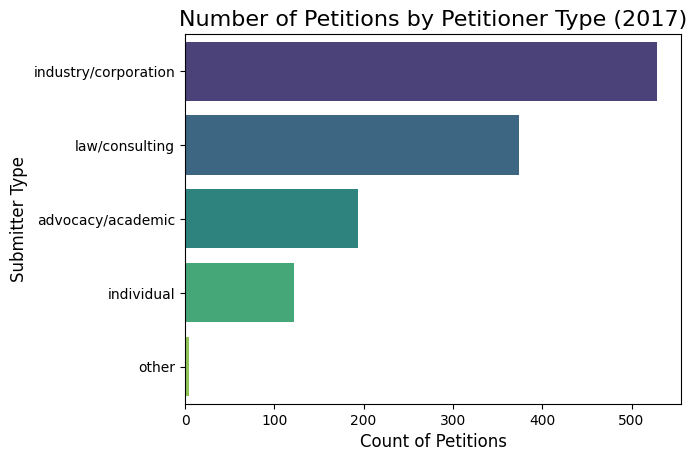

In [3]:
# count of petitions by submitter type 
order = all_years_df["Submitter Type"].value_counts().index
sns.countplot(data = all_years_df, y = "Submitter Type", order = order, palette = "viridis")
plt.title('Number of Petitions by Petitioner Type (2017)', fontsize=16)
plt.xlabel('Count of Petitions', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

#### Quick Analysis of Bar Plot:
* most petitions are filled out by either industry/corps or law/consulting
* avd/aca & individuals tied for having the least (not considering other)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_7732/4253548128.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = all_years_df, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")


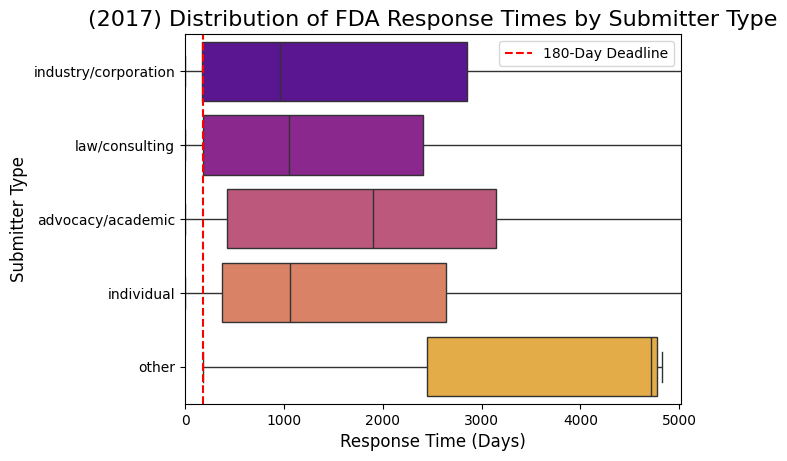

In [4]:
# response time by submitter type 
sns.boxplot(data = all_years_df, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")
plt.title("(2017) Distribution of FDA Response Times by Submitter Type", fontsize=16)
plt.xlabel('Response Time (Days)', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

# Gemini code below
# Limit x-axis to the 95th percentile for better readability, ignoring negative times
plt.xlim(0, all_years_df[all_years_df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x = 180, color = 'r', linestyle = '--', label = '180-Day Deadline')
plt.legend()

#### Quick Analysis of Box Plot (Revised after recleaning data):
* median line splits the data exactly 50/50
  * no submitter category's median line is near the 180-day deadline
  * "other" have the most delayed response time from the fda bc of median line is the furthest, followed by avd/acad, then indus/corp
  * law/consult & indiv about the same in terms median line and box
* box itself is middle 50% (boxplot is split into 25/25/25/25 -> box is middle 50)
  * all submitter categories have similar spread/box size; data is NOT around the 1800 deadline which is BAD bc fda usually take much longer 
* dots are outliers, end of whiskers show minimum and maximum

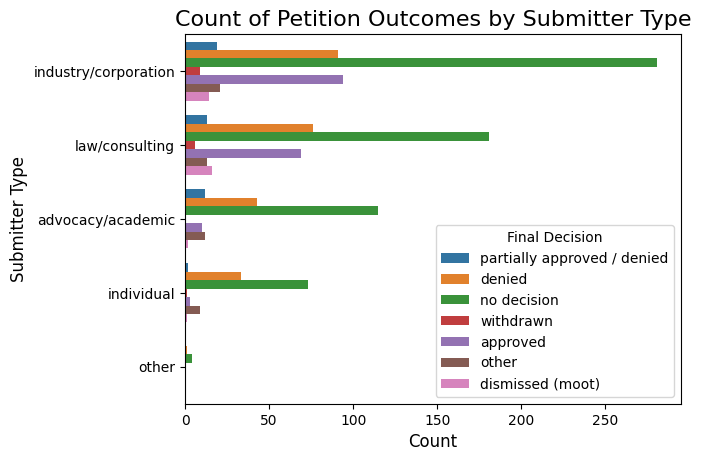

In [5]:
# stacked bar plot of count of petition final decision by submitter type
sns.countplot(data = all_years_df, y = "Submitter Type", hue = "Cleaned Final Decision", order = order)

plt.title("Count of Petition Outcomes by Submitter Type", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Submitter Type", fontsize=12)
plt.legend(title = "Final Decision")

Text(0.5, 1.0, 'Distribution of Response Times')

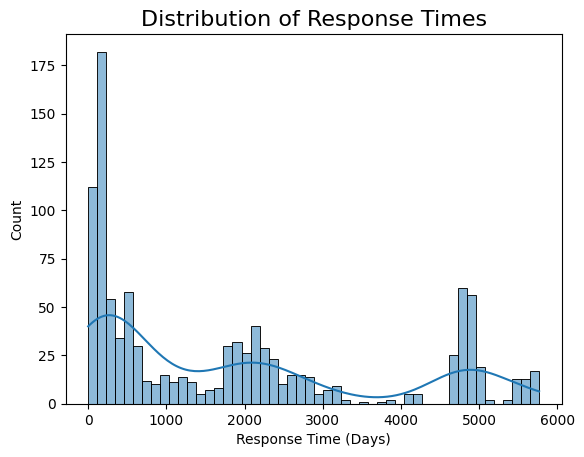

In [6]:
d = all_years_df[all_years_df["Response Time (Days)"] > 0]
sns.histplot(d["Response Time (Days)"].dropna(), kde = True, bins = 50)
plt.title("Distribution of Response Times", fontsize=16)

long tail stretching to the right:
* a decent amount of petitions getting super delayed response time
* supports paper because AHM was able to push forward because of long wait times

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_7732/2712651957.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")


Text(0.5, 1.0, 'Response Time vs. Number of Interim Responses')

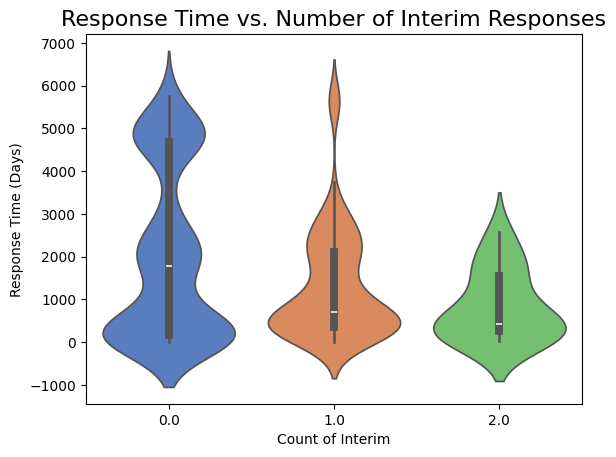

In [7]:
sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")
plt.title("Response Time vs. Number of Interim Responses", fontsize=16)

#### Quick Analysis of Violin Plot:
* box for the data that had 1 interim shows that most of the data get less variability in response times than those with no interim bc of the spread (supports YES interim = shorter response time)
* median line for those with 0 interim versus 1 interim shows that 0 interim get a slower median response time compared to 1 interim (supports YES interim = shorter response time)
* once again the problem is the long tail that goes nearly all the way to 7000 for both interims

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_7732/3515680735.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_years_df, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", palette = "deep", fliersize=0) # fliersize=0 hides outliers; stripplot shows them


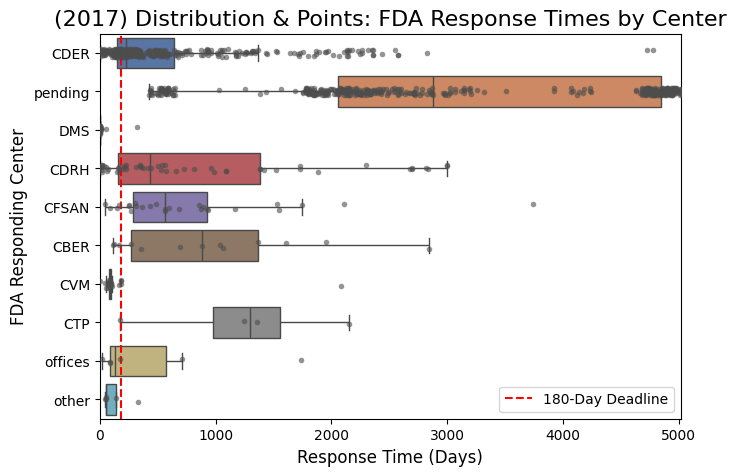

In [8]:
plt.figure(figsize=(7.5, 5))

sns.boxplot(data=all_years_df, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", palette = "deep", fliersize=0) # fliersize=0 hides outliers; stripplot shows them

# overlay the datapoints
sns.stripplot(data=all_years_df, x = "Response Time (Days)", y = "Cleaned FDA Responding Center", color=".3", size=4, alpha=0.6) 

plt.title("(2017) Distribution & Points: FDA Response Times by Center", fontsize=16)
plt.xlabel("Response Time (Days)", fontsize=12)
plt.ylabel("FDA Responding Center", fontsize=12)

# Gemini Code for drawing 180 day line
plt.xlim(0, all_years_df[all_years_df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x=180, color = 'r', linestyle = '--', label='180-Day Deadline')
plt.legend()
plt.show()

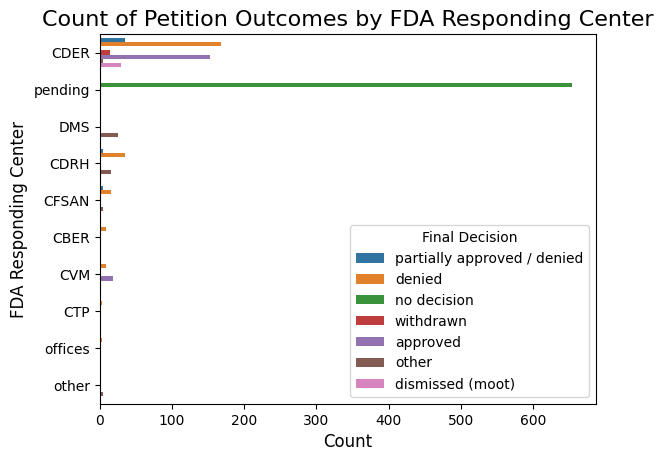

In [9]:
sns.countplot(data = all_years_df, y = "Cleaned FDA Responding Center", hue = "Cleaned Final Decision")

plt.title("Count of Petition Outcomes by FDA Responding Center", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("FDA Responding Center", fontsize=12)
plt.legend(title = "Final Decision")

## Cox PH Model
**features in model:**
* submitter type
* count of interim
* responding fda center
* document type (og or recon, might be more useful when adding the datasets of diff years)
* year

In [10]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import OneHotEncoder

In [11]:
all_years_df.columns

Index(['File ID', 'Petition File Name', 'Date of Petition',
       'Petition Source Year', 'Was_Withdrawn', 'Document Type', 'Submitter',
       'Submitter Type', 'Petition Cited Statutes or Regulations',
       'FDA Action Commented On', 'Requested Action',
       'Justification for Request', 'Interim Response Date', 'Final Decision',
       'Last Response Date', 'Count of Interim',
       'Responding FDA Center (of Final Decision)',
       'Responses Cited Statutes or Regulations',
       'Justification for Interim Response',
       'Justification for Final Response', 'Cleaned Final Decision',
       'Received Final Decision', 'Response Time (Days)',
       'Cleaned FDA Responding Center'],
      dtype='object')

In [12]:
model_df = all_years_df[["Response Time (Days)", "Received Final Decision", "Submitter Type", "Count of Interim", "Cleaned FDA Responding Center", "Document Type", "Petition Source Year"]]

def ohe(data, col):
    # one-hot-encodes categorical features
    oh_enc = OneHotEncoder(drop = "first", sparse_output = False)
    encoded_features = oh_enc.fit_transform(data[[col]])

    # df contains ONLY the new OHE columns
    encoded_cols_df = pd.DataFrame(encoded_features,
                                   columns=oh_enc.get_feature_names_out([col]),
                                   index=data.index)

    data_wo_og_col = data.drop(columns=[col])
    ohe_data = data_wo_og_col.join(encoded_cols_df)

    return ohe_data

data_encoded = model_df.dropna()
data_encoded = ohe(data_encoded, "Submitter Type")
data_encoded = ohe(data_encoded, "Cleaned FDA Responding Center")
data_encoded = ohe(data_encoded, "Document Type")

In [13]:
print("Debugging Checks Before Fitting (model is sensitive)")

# check NaNs in the final df
print("Checking for NaNs:")
nan_counts_final = data_encoded.isnull().sum()
print(nan_counts_final[nan_counts_final > 0])
if nan_counts_final.sum() > 0:
    print("Error: NaNs still present!")

# check for nfinite values
print("\nChecking for Infinite values:")
inf_check = data_encoded.isin([np.inf, -np.inf]).sum()
print(inf_check[inf_check > 0])
if inf_check.sum() > 0:
    print("Error: Infinite values detected!")

# 3. check data types 
print("\nChecking data types again:")
print(data_encoded.info())

# 4. examine duration and event columns specifically
print("\nSummary statistics for Duration and Event:")
print(data_encoded[["Response Time (Days)", "Received Final Decision"]].describe())

print("\nValue counts for Event column:")
print(data_encoded["Received Final Decision"].value_counts())

print("\n--- Checking for Zero-Variance Features ---")
# Calculate the variance for each column
variances = data_encoded.var()

# Find columns with zero or near-zero variance
low_variance_cols = variances[variances < 1e-5] # 1e-5 is a very small number

if not low_variance_cols.empty:
    print("Found columns with zero or very low variance:")
    print(low_variance_cols)
    
    # Drop these problematic columns
    cols_to_drop = low_variance_cols.index.tolist()
    print(f"\nDropping these columns: {cols_to_drop}")
    data_encoded = data_encoded.drop(columns=cols_to_drop)
    
else:
    print("No zero-variance columns found. Problem might be elsewhere.")

Debugging Checks Before Fitting (model is sensitive)
Checking for NaNs:
Series([], dtype: int64)

Checking for Infinite values:
Series([], dtype: int64)

Checking data types again:
<class 'pandas.core.frame.DataFrame'>
Index: 1042 entries, 0 to 1248
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Response Time (Days)                   1042 non-null   float64
 1   Received Final Decision                1042 non-null   bool   
 2   Count of Interim                       1042 non-null   float64
 3   Petition Source Year                   1042 non-null   int64  
 4   Submitter Type_individual              1042 non-null   float64
 5   Submitter Type_industry/corporation    1042 non-null   float64
 6   Submitter Type_law/consulting          1042 non-null   float64
 7   Submitter Type_other                   1042 non-null   float64
 8   Cleaned FDA Responding Center_CD

In [14]:
# STANDARD Cox Model (no regularization) for features EXCLUDING vectorized words
# UNCOMMENT ALL TO USE STANDARD COX MODEL

# verify the required columns exist
required_cols = ["Response Time (Days)", "Received Final Decision"]
if not all(col in data_encoded.columns for col in required_cols):
    print(f"Error: Missing required columns. Ensure 'Response Time (Days)' and 'Received Final Decision' are in the DataFrame.")
    print("Available columns:", data_encoded.columns)
else:
    # create the cox model object 
    # creates an empty model ready to be trained
    cph = CoxPHFitter()
    print("CoxPHFitter object created.")

    # fit model to my data
    try:
        cph.fit(data_encoded,
                duration_col = "Response Time (Days)",
                event_col = "Received Final Decision")

        print("\nModel fitting complete!")

        # view results 
        # print_summary() method displays the main results table
        print("\n--- Cox Proportional Hazards Model Summary ---")
        cph.print_summary(decimals=3) # decimals=3 controls rounding

    except Exception as e:
        print(f"\nAn error occurred during model fitting: {e}")
        print("This might be due to remaining NaN values, non-numeric data, or issues with the duration/event columns.")
        print("Double-check the output of Step 2 (data preparation).")

CoxPHFitter object created.

Model fitting complete!

--- Cox Proportional Hazards Model Summary ---


/Users/anhtran/Library/Python/3.9/lib/python/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column Cleaned FDA Responding Center_CDER have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Received Final Decision'].astype(bool)
>>> print(df.loc[events, 'Cleaned FDA Responding Center_CDER'].var())
>>> print(df.loc[~events, 'Cleaned FDA Responding Center_CDER'].var())

A very low variance means that the column Cleaned FDA Responding Center_CDER completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/anhtran/Library/Python/3.9/lib/python/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed success

<lifelines.CoxPHFitter: fitted with 1042 total observations, 477 right-censored observations>
             duration col = 'Response Time (Days)'
                event col = 'Received Final Decision'
      baseline estimation = breslow
   number of observations = 1042
number of events observed = 565
   partial log-likelihood = -2915.150
         time fit was run = 2025-11-20 17:16:56 UTC

---
                                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                
Count of Interim                       -0.313     0.731     0.088          -0.486          -0.140               0.615               0.869
Petition Source Year                    0.049     1.050     0.013           0.024           0.074               1.025               1.076
Submitter Type_individual              -0.342     0.711     0.201          -0.736           0.053               0.479               1.055
Submitter Type_industry/corporation     0.439     1.552     0.144           0.157           0.722               1.170               2.058
Submitter Type_law/consulting           0.153     1.166     0.150          -0.140           0.447               0.869               1.563
Submitter Type_other                   -0.769     0.463     1.025          -2.778           1.239               0.062               3.453
Cleaned FDA Responding Center_CDER      0.319     1.375     0.286          -0.242           0.880               0.785               2.410
Cleaned FDA Responding Center_CDRH      0.375     1.455     0.316          -0.244           0.994               0.784               2.703
Cleaned FDA Responding Center_CFSAN     0.196     1.216     0.348          -0.487           0.878               0.615               2.406
Cleaned FDA Responding Center_CTP       0.143     1.154     0.582          -0.997           1.283               0.369               3.608
Cleaned FDA Responding Center_CVM       1.670     5.313     0.353           0.979           2.361               2.663              10.603
Cleaned FDA Responding Center_DMS       3.883    48.557     0.375           3.149           4.617              23.305             101.169
Cleaned FDA Responding Center_offices   0.917     2.503     0.508          -0.079           1.913               0.924               6.776
Cleaned FDA Responding Center_other     1.864     6.446     0.576           0.735           2.992               2.086              19.919
Cleaned FDA Responding Center_pending -21.287     0.000  1064.498       -2107.665        2065.091               0.000                 inf
Document Type_reconsideration          -0.345     0.708     0.559          -1.442           0.751               0.237               2.120

                                       cmp to      z       p  -log2(p)
covariate                                                             
Count of Interim                        0.000 -3.554 <0.0005    11.364
Petition Source Year                    0.000  3.904 <0.0005    13.367
Submitter Type_individual               0.000 -1.696   0.090     3.477
Submitter Type_industry/corporation     0.000  3.048   0.002     8.762
Submitter Type_law/consulting           0.000  1.024   0.306     1.710
Submitter Type_other                    0.000 -0.751   0.453     1.143
Cleaned FDA Responding Center_CDER      0.000  1.114   0.265     1.914
Cleaned FDA Responding Center_CDRH      0.000  1.188   0.235     2.090
Cleaned FDA Responding Center_CFSAN     0.000  0.562   0.574     0.800
Cleaned FDA Responding Center_CTP       0.000  0.246   0.805     0.312
Cleaned FDA Responding Center_CVM       0.000  4.738 <0.0005    18.823
Cleaned FDA Responding Center_DMS       0.000 10.367 <0.0005    81.241
Cleaned FDA Responding Center_offices   0.000  1.805   0.071     3.814
Cleaned FDA Responding Center_other     0.000  3.238   

In [15]:
summary_df = cph.summary

alpha = 0.05
significant_features = summary_df[summary_df['p'] < alpha]

print(f"\n--- Statistically Significant Feature(s) (p < {alpha}) ---")
display(significant_features)


--- Statistically Significant Feature(s) (p < 0.05) ---


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Count of Interim,-0.313031,0.731227,0.088076,-0.485657,-0.140405,0.615293,0.869006,0.0,-3.554098,3.792780e-04,11.364457
Petition Source Year,0.049053,1.050276,0.012565,0.024426,0.073681,1.024727,1.076464,0.0,3.903857,9.467167e-05,13.366708
Submitter Type_industry/corporation,0.439289,1.551604,0.144123,0.156813,0.721766,1.169777,2.058065,0.0,3.048011,2.303615e-03,8.761884
Cleaned FDA Responding Center_CVM,1.670249,5.313489,0.352508,0.979346,2.361151,2.662714,10.603152,0.0,4.738189,2.156367e-06,18.822966
Cleaned FDA Responding Center_DMS,3.882739,48.557035,0.374526,3.148682,4.616796,23.305324,101.169397,0.0,10.367078,3.500649e-25,81.240580
Cleaned FDA Responding Center_other,1.863537,6.446498,0.575584,0.735413,2.991661,2.086344,19.918737,0.0,3.237646,1.205203e-03,9.696508


### **RECALL:**
**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

---
### Assessing Statistical Significance (p-values for Hazard Ratios)

**Set Significance Level ($\alpha$):** choose a threshold (0.05 aka 5%) to decide if an association is statistically significant; basically a baseline for deciding when to reject the null 

**Hypotheses PER Feature:**

**Null Hypothesis:** the true hazard ratio for this specific feature is equal to 1 (i.e. this feature provides no increase/decrease in the hazard rate compared to the baseline)

**Alternative Hypothesis:** true HR for this specific feature is not equal to 1 (i.e. this feature is associated with either an increase (HR > 1) or decrease (HR < 1) in the hazard rate)

**Evaluate p-value:** for each feature, the model will give a p-value for its coefficient (log-hazard ratio).

* **p-value < $\alpha$**: reject null; conclude there is **statistically significant evidence** that this feature is associated with the response time (hazard rate), i.e. *under the null*, the observed association was unlikely to happen (aka it unlikely to happen under the null), so reject null
* **p-value >= $\alpha$**: fail to reject; there is **not enough statistical evidence** to say this feature is significantly associated with the response time at this significance level

**Note:** a small p-value indicates *confidence* that an association exists, **not** the *strength* of that association (this is the hazard ratio itself, look at previous section)

---

Features failing PH test (p < 0.01): ['Cleaned FDA Responding Center_DMS', 'Cleaned FDA Responding Center_offices', 'Count of Interim', 'Submitter Type_individual', 'Submitter Type_industry/corporation']

   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1042 total observations, 477 right-censored observations>
         test_name = proportional_hazard_test

---
                                            test_statistic      p  -log2(p)
Cleaned FDA Responding Center_CDER    km              0.30   0.58      0.78
                                      rank            0.28   0.60      0.75
Cleaned FDA Responding Center_CDRH    km              3.95   0.05      4.42
                                      rank            4.04   0.04      4.49
Cleaned FDA Responding Center_CFSAN   km              0.20   0.66      0.61
                                      rank            0.19   0.66      0.59
Cleaned FDA Responding Center_CTP     km              0.49   0.48      1.05
                                      rank            0.45   0.50      1.00
Cleaned FDA Responding Center_CVM     km              5.02   0.03      5.32
                                      rank            5.00   0.03      5.30
Cleaned FDA Responding Center_DMS     km             13.48 <0.005     12.02
                                      rank           14.08 <0.005     12.48
Cleaned FDA Responding Center_offices km              6.89   0.01      6.85
                                      rank            6.95   0.01      6.89
Cleaned FDA Responding Center_other   km              1.10   0.29      1.76
                                      rank            1.11   0.29      1.77
Cleaned FDA Responding Center_pending km              0.00   1.00      0.00
                                      rank            0.00   1.00      0.00
Count of Interim                      km             42.92 <0.005     34.03
                                      rank           43.61 <0.005     34.54
Document Type_reconsideration         km              1.67   0.20      2.35
                                      rank            1.75   0.19      2.43
Petition Source Year                  km              2.85   0.09      3.45
                                      rank            2.62   0.11      3.25
Submitter Type_individual             km              7.41   0.01      7.27
                                      rank            7.75   0.01      7.54
Submitter Type_industry/corporation   km             15.00 <0.005     13.18
                                      rank           14.98 <0.005     13.17
Submitter Type_law/consulting         km              5.72   0.02      5.90
                                      rank            5.89   0.02      6.04
Submitter Type_other                  km              0.81   0.37      1.44
                                      rank            0.84   0.36      1.47



1. Variable 'Count of Interim' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Count of Interim', ...]` in
the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Submitter Type_individual' failed the non-proportional test: p-value is 0.0054.

   Advice: with so few unique values (only 2), you can include `strata=['Submitter Type_individual',
...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


3. Variable 'Submitter Type_industry/corporation' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['Submitter
Type_industry/corporation', ...]` in the call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


4. Variable 'Cleaned FDA Responding Center_DMS' 

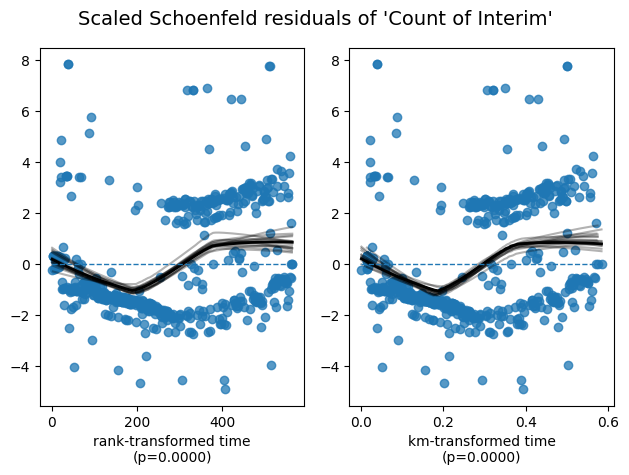

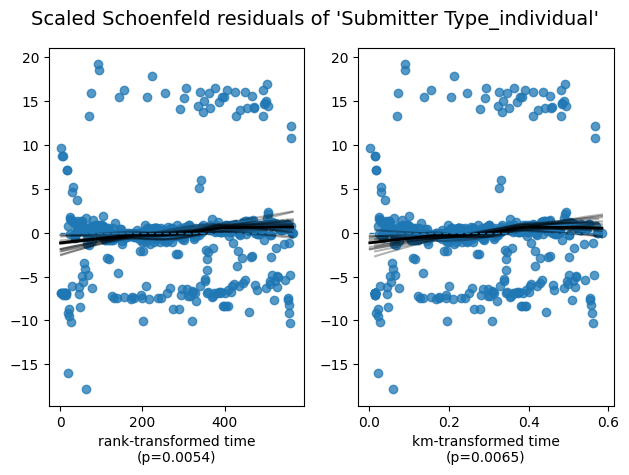

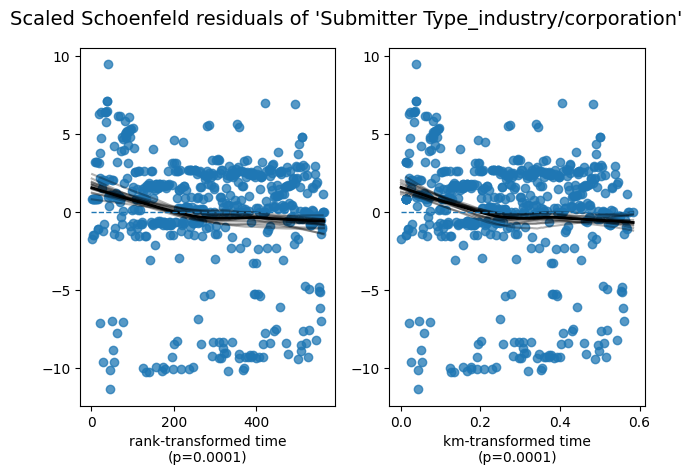

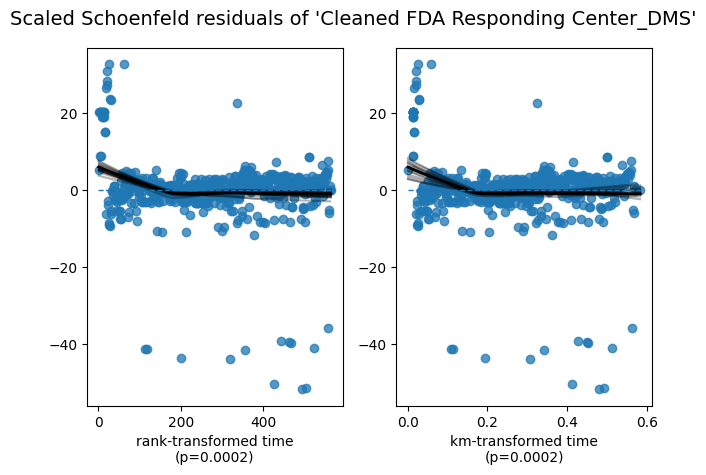

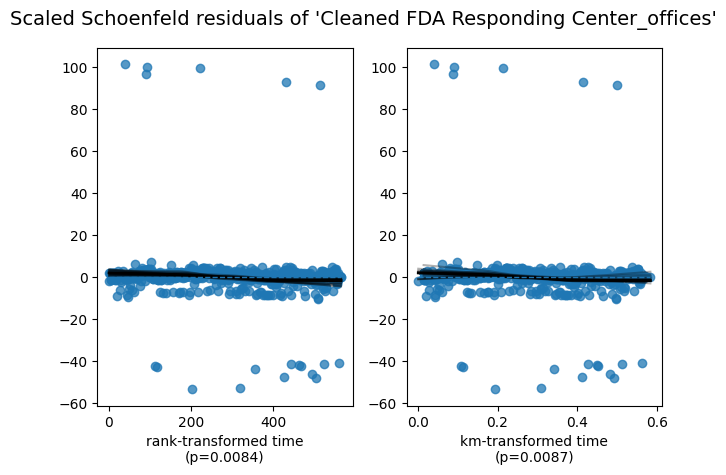

In [16]:
from lifelines.statistics import proportional_hazard_test

p_threshold = 0.01

# run per-covariate PH test
ph_test = proportional_hazard_test(cph, data_encoded, time_transform='rank')
summary = ph_test.summary   # DataFrame with p-values

# list of feature names that fail the test
failing = summary[summary['p'] < p_threshold].index.tolist()

print(f"Features failing PH test (p < {p_threshold}): {failing}")
if failing:
    # show plots only for failing features
    cph.check_assumptions(data_encoded, show_plots=True, p_value_threshold=p_threshold, columns=failing)
else:
    print("No features failed the proportional hazards test.")
